
# EP1 de Programacao Paralela e distribuida - MAC5742
## Analise dos Resultados


| Nome | NUSP |
|------|------|
| Ariel Serranoni Soares da Silva| 7658024 |
| Thiago Martinoni | Numero usp |


### Resumo

O conjunto de Mandelbrot é famoso na matematica. Muitas aulas de computação usam . A implementação sequencial do algorítmo é muito comum em disciplinas introdutórias de computação. Neste trabalho vamos além, vamos implementar três versões do algorítmo, a clássica sequencial, uma utilizando pthreads e uma terceira utilizando open mp. Os códigos em C e seus encontram-se disponíveis em bla. Aqui vamos analisar o desempenho de cada algorítmo afim de obter um parâmetro de comparação a respeito do 
desempenho dessas bibliotecas.

### Implementações em C

Temos três arquivos, cada um responsável por calcular o conjunto de mandelbrot utilizando um método diferente. O Programa
mandelbrot_seq serve como base para os outros dois. 
Notando que cada iteração do loop exterior na função compute_mandelbrot é responsável por produzir uma linha completa da imagem
final e que cada linha é independente. adotamos isso como unidade elementar e distribuímos o trabalho entre múltiplas threads

Nas implementações em paralelo, utilizamos a estratégia de divisão estática
tanto no programa mandelbrot_pth quanto no mandelbrot_omp afim de obter uma comparação mais justa possível. Por isso deixamos todas as varíavei

Quando o usuário solicita um número maior de threads do que de linhas na imagem
Medições de tempo e output usamos do EP anterior.

### Infra estrutura Julia

Para este relatório, usamos jupyter notebooks e Julia, conforme nos eps anteriores. Também usamos os mesmos pacotes e muitas das funções do nosso último trabalho adaptadas ao novo problema. A seguinte célula fará as instalações de pacotes julia  

In [1]:
]up

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Installed PositiveFactorizations ─────── v0.2.3
  Installed PooledArrays ───────────────── v0.5.3
  Installed StatsPlots ─────────────────── v0.14.6
  Installed Query ──────────────────────── v0.12.2
  Installed PGFPlotsX ──────────────────── v1.2.6
  Installed DataFrames ─────────────────── v0.21.1
  Installed Distributions ──────────────── v0.23.2
  Installed Rmath_jll ──────────────────── v0.2.2+0
  Installed Ogg_jll ────────────────────── v1.3.4+0
  Installed TableOperations ────────────── v0.2.1
  Installed TableShowUtils ─────────────── v0.2.5
  Installed RecipesPipeline ────────────── v0.1.9
  Installed Colors ─────────────────────── v0.12.1
  Installed CSV ────────────────────────── v0.6.2
  Installed Arpack ─────────────────────── v0.4.0
  Installed DataValueInterfaces ────────── v1.0.0
  Installed Parameters ─────────────────── v0.12.1
  Installed FilePathsBase ──────────────── v0.8.0
  Installed Plots ──────────────────────── v1.3.4
  Installed LibVPX_jll ─────────────────

  [2913bbd2] + StatsBase v0.33.0
  [4c63d2b9] + StatsFuns v0.9.5
  [f3b207a7] + StatsPlots v0.14.6
  [ab02a1b2] + TableOperations v0.2.1
  [5e66a065] + TableShowUtils v0.2.5
  [3783bdb8] + TableTraits v1.0.0
  [382cd787] + TableTraitsUtils v1.0.1
  [bd369af6] + Tables v1.0.4
  [3a884ed6] + UnPack v1.0.1
  [81def892] + VersionParsing v1.2.0
  [ea10d353] + WeakRefStrings v0.6.2
  [cc8bc4a8] + Widgets v0.6.2
  [efce3f68] + WoodburyMatrices v0.5.2
  [c2297ded] + ZMQ v1.2.0
  [8f1865be] + ZeroMQ_jll v4.3.2+3
  [83775a58] + Zlib_jll v1.2.11+10
  [0ac62f75] + libass_jll v0.14.0+2
  [f638f0a6] + libfdk_aac_jll v0.1.6+2
  [f27f6e37] + libvorbis_jll v1.3.6+4
  [1270edf5] + x264_jll v2019.5.25+2
  [dfaa095f] + x265_jll v3.0.0+1
  [2a0f44e3] + Base64 
  [ade2ca70] + Dates 
  [8bb1440f] + DelimitedFiles 
  [8ba89e20] + Distributed 
  [7b1f6079] + FileWatching 
  [9fa8497b] + Future 
  [b77e0a4c] + InteractiveUtils 
  [76f85450] + LibGit2 
  [8f399da3] + Libdl 
  [37e2e46d] + LinearAlgebra 
  [56ddb

In [ ]:
Tambem podemos verificar se ha algum problema rodando a seguinte celula

In [2]:
] st

Status `/mnt/c/Users/Ariel/Desktop/EP1/src/Project.toml`
  [336ed68f] CSV v0.6.2
  [a93c6f00] DataFrames v0.21.1
  [31c24e10] Distributions v0.23.2
  [7073ff75] IJulia v1.21.2
  [8314cec4] PGFPlotsX v1.2.6
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6


### Experimentos

O Primeiro passo para analisarmos


In [72]:
using DataFrames, Query, StatsPlots, Statistics

function mandelbrot(method, c_x_min, c_x_max, c_y_min, c_y_max, image_size, threads=1)
    results = parse.(Float64,
        split(chomp(read(`./mandelbrot_$method $c_x_min $c_x_max $c_y_min $c_y_max $image_size $threads`, String)), ", "))
        
    return DataFrame(size = image_size,
                delta_x = c_x_max - c_x_min,
                delta_y = c_y_max - c_y_min,
                duration_clock = results[1],
                duration_mono = results[2],
                duration_sys = results[3],
                threads=threads,
                method=method)
    end
 

,size,delta_x,delta_y,duration_clock,duration_mono,duration_sys,threads,method
,Int64,Int64,Int64,Float64,Float64,Float64,Int64,String
1,1000,1,1,0.352759,0.352754,0.352754,2,seq


mais uma outra funcao do miniEP3 adaptada para o nosso caso

In [186]:
function run_experiments(methods,c_x_min, c_x_max, c_y_min, c_y_max, image_size, threads, repetitions)
    run(`make`)
    
    results = DataFrame(size = Int64[],
                delta_x = Float64[],
                delta_y = Float64[],
                duration_clock = Float64[],
                duration_mono = Float64[],
                duration_sys = Float64[],
                threads= Int64[],
                method= String[])
    
    for method in methods
        for size in image_size
            for t in 1:length(threads)
                if (threads[t] <= 1 || method != "seq") 
                    for r in 1:repetitions
                        append!(results,
                            mandelbrot(method,c_x_min, c_x_max, c_y_min, c_y_max, size, threads[t]))
                
                    end
                end
            end
        end
    end
    return results
end

make: Nothing to be done for 'all'.
123123123

,size,delta_x,delta_y,duration_clock,duration_mono,duration_sys,threads,method
,Int64,Float64,Float64,Float64,Float64,Float64,Int64,String
1,1000,1.0,1.0,0.357669,0.357665,0.357665,1,seq
2,1000,1.0,1.0,0.355612,0.355639,0.355639,1,seq
3,1000,1.0,1.0,0.361766,0.36176,0.361761,1,seq
4,1000,1.0,1.0,0.355489,0.355528,0.355529,1,seq
5,1000,1.0,1.0,0.355651,0.355646,0.355646,1,seq
6,1000,1.0,1.0,0.353688,0.353713,0.353713,1,seq
7,1000,1.0,1.0,0.354275,0.354271,0.35427,1,seq
8,1000,1.0,1.0,0.35352,0.353515,0.353515,1,seq
9,1000,1.0,1.0,0.355359,0.355354,0.355354,1,seq


In [196]:
function parse_results(results)
    parsed_results=results|>
                @groupby((_.threads,_.method)) |>
                @map({threads_method = key(_),
                repetitions=repetitions,
                size = mean(_.size),
                delta_x = mean(_.delta_x),
                delta_y = mean(_.delta_y),
                mean_duration_clock = mean(_.duration_clock),
                mean_duration_mono = mean(_.duration_mono),
                mean_duration_sys = mean(_.duration_sys),
                ci_duration_clock = 1.96 * std(_.duration_clock),
                ci_duration_mono = 1.96 * std(_.duration_mono),
                ci_duration_sys = 1.96 * std(_.duration_sys)})|>
                DataFrame
    
      final_results = DataFrame(threads= Int64[],
                    method= String[],
                    size = Int64[],
                    delta_x = Float64[],
                    delta_y = Float64[],
                    mean_duration_clock = Float64[],
                    mean_duration_mono = Float64[],
                    mean_duration_sys = Float64[],
                    ci_duration_clock = Float64[],
                    ci_duration_mono = Float64[],
                    ci_duration_sys = Float64[],
                    repetitions = Int64[])
    
        for i in 1:length(parsed_results.size)
            append!(final_results, DataFrame(size=parsed_results.size[i],
                                        delta_x=parsed_results.delta_x[i],
                                         delta_y=parsed_results.delta_y[i],
                                        mean_duration_clock=parsed_results.mean_duration_clock[i],
                                        mean_duration_mono=parsed_results.mean_duration_mono[i],
                                        mean_duration_sys=parsed_results.mean_duration_sys[i],
                                        ci_duration_clock=parsed_results.ci_duration_clock[i],
                                        ci_duration_mono=parsed_results.ci_duration_mono[i],
                                        ci_duration_sys=parsed_results.ci_duration_sys[i],
                                        repetitions =parsed_results.repetitions[i],
                                        threads = parsed_results.threads_method[i][1],
                                        method = parsed_results.threads_method[i][2]))
    
        end
    return final_results
end

,threads,method,size,delta_x,delta_y,mean_duration_clock,mean_duration_mono
,Int64,String,Int64,Float64,Float64,Float64,Float64
1,1,seq,5000,1.0,1.0,8.93245,8.93292
2,1,pth,5000,1.0,1.0,9.02787,9.0325
3,2,pth,5000,1.0,1.0,9.2572,7.32838
4,4,pth,5000,1.0,1.0,10.4846,4.16838
5,8,pth,5000,1.0,1.0,11.7929,3.19837
6,16,pth,5000,1.0,1.0,11.8579,3.01767
7,32,pth,5000,1.0,1.0,11.7653,3.00284
8,1,omp,5000,1.0,1.0,9.23445,9.23489
9,2,omp,5000,1.0,1.0,9.10392,7.23081


In [225]:
sizes=[1000,2000,4000,6000,8000]
threads = [2 ^ x for x in 0:10]
methods = ["seq","pth","omp"]
repetitions=10
results = run_experiments(methods,0, 1, 0, 1, sizes, threads, repetitions)
parsed_results = parse_results(results)

make: Nothing to be done for 'all'.
124816326412825651210241248163264128256512102412481632641282565121024

,threads,method,size,delta_x,delta_y,mean_duration_clock,mean_duration_mono
,Int64,String,Int64,Float64,Float64,Float64,Float64
1,1,seq,5000,1.0,1.0,8.84548,8.84575
2,1,pth,5000,1.0,1.0,8.84871,8.85328
3,2,pth,5000,1.0,1.0,9.39295,7.4431
4,4,pth,5000,1.0,1.0,10.5912,4.19684
5,8,pth,5000,1.0,1.0,12.5237,3.37275
6,16,pth,5000,1.0,1.0,12.3479,3.15299
7,32,pth,5000,1.0,1.0,12.1102,3.08675
8,64,pth,5000,1.0,1.0,11.9672,3.07377
9,128,pth,5000,1.0,1.0,12.387,3.22712


In [41]:
using CSV

function save_csv_results(data_frame)
    CSV.write("./data_frame.csv",data_frame,delim='\t')
end

function read_csv_results()
    df=CSV.read("./data_frame.csv")
    return df
end

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1260


save_csv_results (generic function with 1 method)

In [219]:
pgfplotsx()

function plot_results(x, y, group, target_label, series_label; hline = [], yerror = [], max_thread_power = 10)
    if yerror != []
        s = scatter(x,
            y,
            xaxis = :log2,
            group=group,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror,
            alpha = 100,
            labels = series_label,
            legend = :topright)
    else
        p = scatter(x,
            y,
            xaxis = :log2,
            group=group,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            alpha = 0.6,
            labels = series_label,
            legend = :topright)
    end

    if hline != []
        plot!(x,
            hline,
            xaxis = :log2,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            labels = target_label,
            line = :dash,
            width = 2.0)
    end

    return p
end


plot_results (generic function with 3 methods)

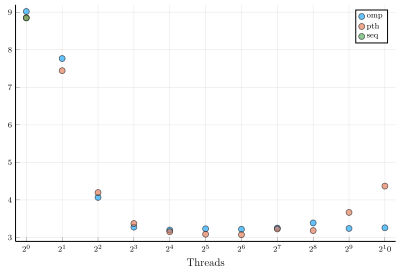

In [227]:
plot_results(parsed_results.threads,
    parsed_results.mean_duration_sys,
    parsed_results.method,
    "",
    parsed_results.method,
    max_thread_power = 10)